In [1]:
import pandas as pd
import yfinance as yf
import vectorbt as vbt

### Cruzamento de médias móveis

Teste da estratégia de cruzamento de médias móveis utilizando o Vectorbt como ferramenta de backtest.

As médias móveis são definidas pela quantidade de períodos incluídos no cálculo. Normalmente usa-se uma quantidade de períodos menor em conjunto com outra de maior quantidade de períodos.

Quando a média curta passa para cima da média longa pode significar uma tendência de alta e de baixa quando o contrário ocorre.

As médias móveis são usadas há anos pela estatística para suavizar valores em séries temporais, filtrando ruído provocado por flutuações de curto prazo e destacando tendências ou ciclos de longo prazo.

Fonte: https://smarttbot.com/trader/medias-moveis-para-day-trade/

In [2]:
# Histórico do Índice Ibovespa

dados = vbt.YFData.download('^BVSP', end='2023-04-26').get()

In [3]:
dados.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-18 03:00:00+00:00,106023.0,106475.0,105122.0,106163.0,11207900,0.0,0.0
2023-04-19 03:00:00+00:00,106149.0,106149.0,103604.0,103913.0,12713600,0.0,0.0
2023-04-20 03:00:00+00:00,103913.0,104615.0,103087.0,104367.0,12378000,0.0,0.0
2023-04-24 03:00:00+00:00,104367.0,104822.0,103247.0,103947.0,10935400,0.0,0.0
2023-04-25 03:00:00+00:00,103947.0,103947.0,102633.0,103220.0,10873200,0.0,0.0


<AxesSubplot:xlabel='Date'>

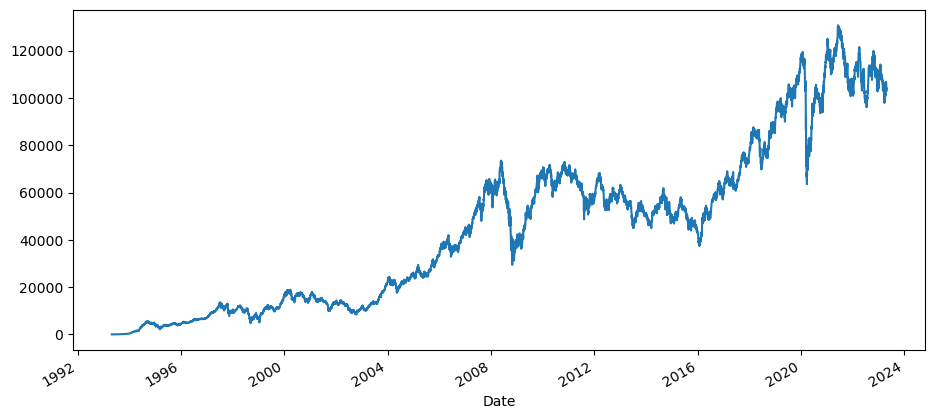

In [4]:
dados['Close'].plot(figsize=(11,5))

In [5]:
fechamento = dados['2012':]['Close'].copy()

Calculando as médias móveis

In [6]:
media_curta = vbt.MA.run(fechamento, 10) # dias (média rápida)
media_longa = vbt.MA.run(fechamento, 60) # dias (média lenta)

***

### Estratégia

* **COMPRAR** (= +1) média curta passa para cima da média longa.
* **VENDER** (= -1) a média curta voltar para baixo da média longa.

In [7]:
compras = media_curta.ma_crossed_above(media_longa)
vendas = media_curta.ma_crossed_below(media_longa)

Execução do backtest considerando os sinais de compra e venda calculados anteriormente

In [8]:
pf = vbt.Portfolio.from_signals(fechamento, compras, vendas, freq='d', init_cash=1000)

In [9]:
pf.total_return()

1.0689334238819215

In [10]:
pf.sharpe_ratio()

0.6042793159065077

Gráfico das ordens: compras (buy) e vendas (sell)

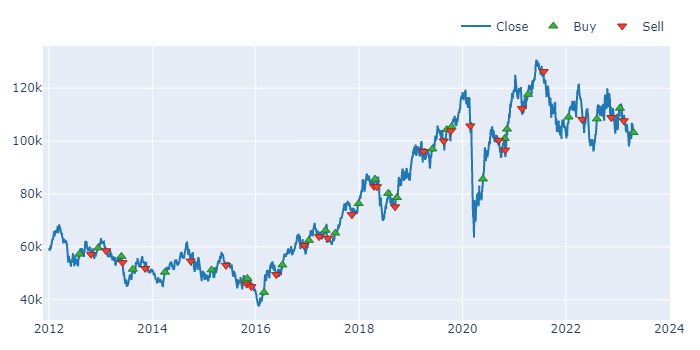

In [11]:
pf.plot_orders().show_png()

### Comparando a estratégia com a oopção Long Only

In [12]:
import pandas as pd

In [13]:
retornos_long_only = fechamento.pct_change() 

In [14]:
estrategias = pd.concat([pf.returns(), retornos_long_only], axis=1)
estrategias.columns = ['Cruzamento MM', 'Long Only']

In [15]:
estrategias.tail()

,Cruzamento MM,Long Only
Date,,
2023-04-18 03:00:00+00:00,0.0,0.001387
2023-04-19 03:00:00+00:00,0.0,-0.021194
2023-04-20 03:00:00+00:00,0.0,0.004369
2023-04-24 03:00:00+00:00,0.0,-0.004024
2023-04-25 03:00:00+00:00,0.0,-0.006994


In [16]:
retornos = (estrategias + 1).cumprod()-1 # obtendo o retorno acumulado

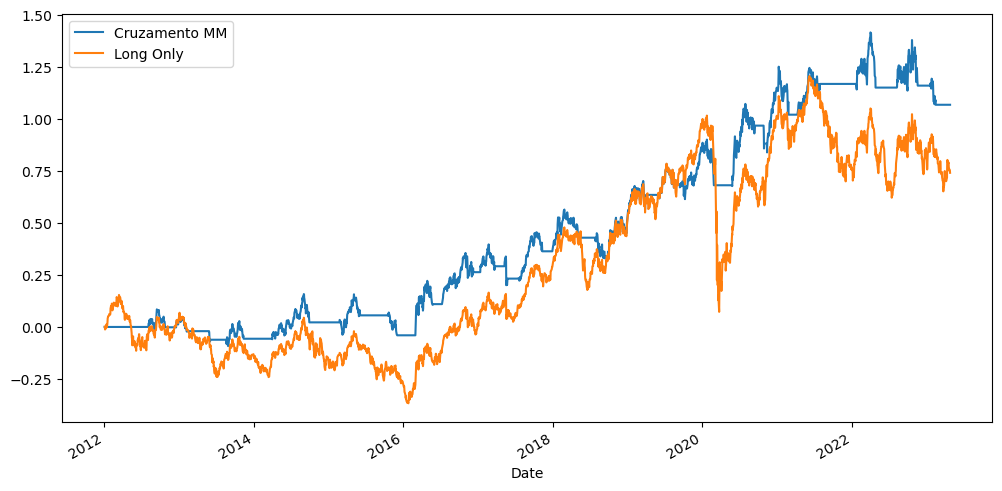

In [17]:
retornos.plot(figsize=(12,6));

In [18]:
# Retorno final de cada estratégia
retornos.tail(1)

,Cruzamento MM,Long Only
Date,,
2023-04-25 03:00:00+00:00,1.068933,0.741669


### Quais os sinais dos últimos 5 dias?

In [19]:
sinais = pd.concat([compras, vendas], axis=1)
sinais.columns = ['Compra', 'Venda']

In [20]:
sinais.tail(5)

,Compra,Venda
Date,,
2023-04-18 03:00:00+00:00,False,False
2023-04-19 03:00:00+00:00,False,False
2023-04-20 03:00:00+00:00,False,False
2023-04-24 03:00:00+00:00,False,False
2023-04-25 03:00:00+00:00,True,False
